## __Import__

Bayern - Wolfsburg: 3890305
Hoffenheim - Schalke: 3890561

In [1]:
import pandas as pd
import numpy as np
from statsbombpy import sb
from ast import literal_eval
from dataloader import load_data
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch



all_columns = ["player", "position", "type", "location", "minute", "shot_aerial_won", "play_pattern", "shot_body_part", "shot_end_location" ,
           "shot_first_time","shot_outcome","shot_statsbomb_xg", "shot_technique", "shot_type", "shot_follows_dribble", 
           "under_pressure"]
some_columns=["player", "position", "type", "location", "minute", "shot_aerial_won", "play_pattern", "shot_body_part", "shot_end_location" ,
           "shot_first_time","shot_outcome","shot_statsbomb_xg", "shot_technique", "shot_type", 
           "under_pressure"]

def load_event_data(match=False):
    if match:
        COMPETITION_ID = 9
        SEASON_ID = 27
        MATCH_ID = 3890561 
        events = sb.events(match_id=MATCH_ID)
        df = events.loc[events["type"] == "Shot", some_columns] # [row, column] selector
        print(df.shape, df.columns)
        return df
    else:
        df = load_data(frac=0.1)
        df = df.loc[df["type"] == "Shot", all_columns] 
        print(df.shape, df.columns)
        return df

df = load_event_data(match=False)

Loading data form local file system


/Users/alexanderlorenz/Documents/GitHub/ai-fc/src/dataloader.py:33: DtypeWarning: Columns (3,11,13,17,19,40,41,43,66,72,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path).sample(frac=frac, random_state=42)


File loaded with shape: (106987, 116)
(768, 16) Index(['player', 'position', 'type', 'location', 'minute', 'shot_aerial_won',
       'play_pattern', 'shot_body_part', 'shot_end_location',
       'shot_first_time', 'shot_outcome', 'shot_statsbomb_xg',
       'shot_technique', 'shot_type', 'shot_follows_dribble',
       'under_pressure'],
      dtype='object')


In [2]:
for col in df.columns:
    if "shot" in col:
        print(col)

shot_aerial_won
shot_body_part
shot_end_location
shot_first_time
shot_outcome
shot_statsbomb_xg
shot_technique
shot_type
shot_follows_dribble


## __Visualize all Shot Attempts__

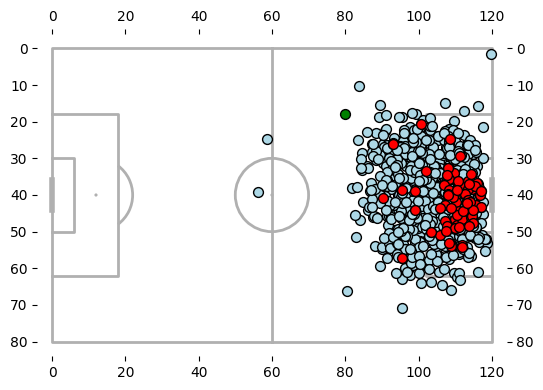

In [3]:
all_shots = np.vstack([literal_eval(shot) for shot in df["location"]])
goals = np.vstack([literal_eval(shot) for shot in df[df['shot_outcome'] == 'Goal']['location']]) # [literal_eval(shot) for shot in df[df['shot_outcome'] == 'Goal']['location']]

pitch = Pitch(label=True, tick=True)
#pitch = Pitch(pitch_type="custom", pitch_length=105,pitch_width=68 ,label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

ax.scatter(all_shots[:, 0], all_shots[:, 1], c='lightblue', s=50, edgecolors='black', zorder=5)
ax.scatter(goals[:, 0], goals[:, 1], c='red', s=50, edgecolors='black', zorder=5)
ax.scatter(2 * (120/3) , (40- 22), c='green', s=50, edgecolors='black', zorder=5)
plt.show()


In [4]:
start = np.array([108.1, 31.2])
end = np.array([120.0, 35.2])

np.linalg.norm(start - end)

12.55428213797986

## __Creation of Total Values__

In [5]:
df.columns

Index(['player', 'position', 'type', 'location', 'minute', 'shot_aerial_won',
       'play_pattern', 'shot_body_part', 'shot_end_location',
       'shot_first_time', 'shot_outcome', 'shot_statsbomb_xg',
       'shot_technique', 'shot_type', 'shot_follows_dribble',
       'under_pressure'],
      dtype='object')

In [6]:
df.loc[df["player"] == "Arjen Robben",["player","shot_statsbomb_xg","shot_outcome"]]

,player,shot_statsbomb_xg,shot_outcome
357689,Arjen Robben,0.027391,Off T
331790,Arjen Robben,0.025423,Saved
357688,Arjen Robben,0.019972,Goal


In [ ]:
def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None


def is_in_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    if is_in_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_in_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    if is_in_goal_area(location) or is_in_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_middle_third(location):
    #print("Executing is_in_middle_third method")
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    return (1 * (pitch_width / 3)) <= x <= (2 * (pitch_width / 3))

def is_long_distance_shot(start_location, end_location):
    #print("Executing is_long_distance_shot method")

    if isinstance(start_location, str):
        start_location = convert_to_list(start_location)

    if isinstance(end_location, str):
        end_location = convert_to_list(end_location)

    x_start = start_location[0]
    y_start = start_location[1]
    x_end = end_location[0]
    y_end = end_location[1]

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])
    distance = np.linalg.norm(start - end)

    return (distance >= 20)

def is_mid_distance_shot(start_location, end_location):
    #print("Executing is_mid_distance_shot method")
    if isinstance(start_location, str):
        start_location = convert_to_list(start_location)

    if isinstance(end_location, str):
        end_location = convert_to_list(end_location)

    x_start = start_location[0]
    y_start = start_location[1]
    x_end = end_location[0]
    y_end = end_location[1]

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])
    distance = np.linalg.norm(start - end)
    return (10 < distance < 20)

def is_short_distance_shot(start_location, end_location):
    #print("Executing is_short_distance_shot method")
    if isinstance(start_location, str):
        start_location = convert_to_list(start_location)

    if isinstance(end_location, str):
        end_location = convert_to_list(end_location)

    x_start = start_location[0]
    y_start = start_location[1]
    x_end = end_location[0]
    y_end = end_location[1]

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])
    distance = np.linalg.norm(start - end)
    return (distance <= 10)

def get_shot_distance(start_location, end_location):
    #print("Executing is_short_distance_shot method")
    if isinstance(start_location, str):
        start_location = convert_to_list(start_location)

    if isinstance(end_location, str):
        end_location = convert_to_list(end_location)

    x_start = start_location[0]
    y_start = start_location[1]
    x_end = end_location[0]
    y_end = end_location[1]

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])

    return np.linalg.norm(start - end)

def is_big_chance(xG, start_location, end_location, treshold_xG=0.3, treshold_dist=11):
    if isinstance(start_location, str):
        start_location = convert_to_list(start_location)

    if isinstance(end_location, str):
        end_location = convert_to_list(end_location)

    x_start = start_location[0]
    y_start = start_location[1]
    x_end = end_location[0]
    y_end = end_location[1]

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])

    return (xG >= treshold_xG and np.linalg.norm(start - end) <= treshold_dist)


df['under_pressure'] = df['under_pressure'].fillna(False)

# Create player statistics

player_under_pressure_grouping = df[df['type'] == 'Shot'].groupby(['player',"under_pressure"]).agg(
    goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
    goals_penalty=("shot_outcome", lambda x: ((x == 'Goal') & (df["shot_type"] == "Penalty")).sum()),
    shots_total=('shot_outcome', "count"), # optionally: sum
    shots_on_target=('shot_outcome', lambda x: ((x != 'Off T') & (x != 'Wayward') & (x != 'Saved Off T')).sum()),
    shots_from_freekick = ('shot_type', lambda x: (x == "Free Kick").sum()),
    shots_from_penalty = ('shot_type', lambda x: (x == "Penalty").sum()), 
    shots_on_target_left_foot = ("shot_body_part", lambda x: (x == "Left Foot").sum()),
    shots_on_target_right_foot = ("shot_body_part", lambda x: (x == "Right Foot").sum()),
    goals_from_left_foot=('shot_body_part', lambda x: ((df['shot_outcome'] == 'Goal') & (x == 'Left Foot')).sum()),
    goals_from_right_foot=('shot_body_part', lambda x: ((df['shot_outcome'] == 'Goal') & (x == 'Right Foot')).sum()),
    goals_from_head=('shot_body_part', lambda x: ((df['shot_outcome'] == 'Goal') & (x == 'Head')).sum()),
    goals_after_first_touch=('shot_first_time', lambda x: ((df['shot_outcome'] == 'Goal') & (x == True)).sum()),
    goals_in_penalty_area=("location", lambda x: x[df.loc[x.index, "shot_outcome"] == "Goal"].apply(is_in_penalty_area).sum()),
    goals_in_goal_area=("location", lambda x: x[df.loc[x.index, "shot_outcome"] == "Goal"].apply(is_in_goal_area).sum()),
    goals_in_attacking_third=("location", lambda x: x[df.loc[x.index, "shot_outcome"] == "Goal"].apply(is_in_attacking_third).sum()),
    goals_in_middle_third=("location", lambda x: x[df.loc[x.index, "shot_outcome"] == "Goal"].apply(is_in_middle_third).sum()),
    goals_long_distance=(("location"), lambda x: sum(
                             is_long_distance_shot(start, end) 
                             for start, end, idx in zip(x, df.loc[x.index, "shot_end_location"], x.index)
                             if df.loc[idx, "shot_outcome"] == "Goal"
                         )),
    goals_mid_distance=(("location"), lambda x: sum(
                             is_mid_distance_shot(start, end) 
                             for start, end, idx in zip(x, df.loc[x.index, "shot_end_location"], x.index)
                             if df.loc[idx, "shot_outcome"] == "Goal"
                         )),
    goals_short_distance=(("location"), lambda x: sum(
                             is_short_distance_shot(start, end) 
                             for start, end, idx in zip(x, df.loc[x.index, "shot_end_location"], x.index)
                             if df.loc[idx, "shot_outcome"] == "Goal"
                         )),
    goals_avg_distance=(("location"), lambda x: 
                             np.average([get_shot_distance(start, end) for start, end, idx in zip(x, df.loc[x.index, "shot_end_location"], x.index) if df.loc[idx, "shot_outcome"] == "Goal"]).round(2) 
                         ),  
    shots_in_penalty_area=("location", lambda x: x.apply(is_in_penalty_area).sum()),
    shots_in_goal_area=("location", lambda x: x.apply(is_in_goal_area).sum()),
    shots_in_attacking_third=("location", lambda x: x.apply(is_in_attacking_third).sum()),
    shots_in_middle_third=("location", lambda x: x.apply(is_in_middle_third).sum()),
    shots_long_distance=(("location"), lambda x: sum(
                             is_long_distance_shot(start, end) 
                             for start, end in zip(x, df.loc[x.index, "shot_end_location"])  # Use corresponding 'shot_end_location' for each 'location'
                         )),
    shots_mid_distance=(("location"), lambda x: sum(
                             is_mid_distance_shot(start, end) 
                             for start, end in zip(x, df.loc[x.index, "shot_end_location"])  # Use corresponding 'shot_end_location' for each 'location'
                         )),
    shots_short_distance=(("location"), lambda x: sum(
                             is_short_distance_shot(start, end) 
                             for start, end in zip(x, df.loc[x.index, "shot_end_location"])  # Use corresponding 'shot_end_location' for each 'location'
                         )),
    shots_avg_distance=(("location"), lambda x: 
                             np.average([get_shot_distance(start, end) for start, end in zip(x, df.loc[x.index, "shot_end_location"])]).round(2)   # Use corresponding 'shot_end_location' for each 'location'
                         ),                     
    shots_volley=("shot_technique", lambda x: (x == "Volley").sum()),
    shots_half_volley=("shot_technique", lambda x: (x == "Half Volley").sum()),
    shots_normal=("shot_technique", lambda x: (x == "Normal").sum()),
    shots_lob=("shot_technique", lambda x: (x == "Lob").sum()),
    shots_backheel=("shot_technique", lambda x: (x == "Backheel").sum()),
    shots_overhead_kick=("shot_technique", lambda x: (x == "Overhead Kick").sum()),
    shots_diving_header=("shot_technique", lambda x: (x == "Diving Header").sum()),
    shots_after_aerial_duel_won=("shot_aerial_won", lambda x: (x == True).sum()),
    shots_after_dribbling=("shot_follows_dribble", lambda x: (x == True).sum()),
    xG=("shot_statsbomb_xg", lambda x: x.sum()),
    big_chances=("shot_statsbomb_xg", lambda x: sum(
        is_big_chance(xG, start, end) for xG, start, end in zip(x, df.loc[x.index, "location"], df.loc[x.index, "shot_end_location"])
    )),
    big_chances_led_to_goal=("shot_statsbomb_xg", lambda x: sum(
        is_big_chance(xG, start, end) for xG, start, end, idx in zip(x, df.loc[x.index, "location"], df.loc[x.index, "shot_end_location"], x.index)
        if df.loc[idx, "shot_outcome"] == "Goal"
    ))
)

player_under_pressure_grouping["shots_inside_the_box"] = player_under_pressure_grouping["shots_in_penalty_area"] + player_under_pressure_grouping["shots_in_goal_area"]
player_under_pressure_grouping["shots_outside_the_box"] = player_under_pressure_grouping["shots_total"] - player_under_pressure_grouping["shots_inside_the_box"]
player_under_pressure_grouping["goals_inside_the_box"] = player_under_pressure_grouping["goals_in_penalty_area"] + player_under_pressure_grouping["goals_in_goal_area"]
player_under_pressure_grouping["goals_outside_the_box"] = player_under_pressure_grouping["goals"] - player_under_pressure_grouping["goals_inside_the_box"]

total_stats = player_under_pressure_grouping.groupby('player').sum()
total_stats

/Users/alexanderlorenz/anaconda3/envs/ml/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/alexanderlorenz/anaconda3/envs/ml/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,goals,goals_penalty,shots_total,shots_on_target,shots_from_freekick,shots_from_penalty,shots_on_target_left_foot,shots_on_target_right_foot,goals_from_left_foot,goals_from_right_foot,...,shots_diving_header,shots_after_aerial_duel_won,shots_after_dribbling,xG,big_chances,big_chances_led_to_goal,shots_inside_the_box,shots_outside_the_box,goals_inside_the_box,goals_outside_the_box
player,,,,,,,,,,,,,,,,,,,,,
Aaron Hunt,0,0,3,3,0,0,3,0,0,0,...,0,0,0,0.278667,0,0,2,1,0,0
Adelino André Vieira Freitas,0,0,3,3,0,0,1,2,0,0,...,0,0,0,0.269305,0,0,1,2,0,0
Admir Mehmedi,0,0,2,2,0,0,0,2,0,0,...,0,0,0,0.073318,0,0,2,0,0,0
Adnan Januzaj,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0.082743,0,0,0,1,0,0
Albin Ekdal,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0.033529,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zlatko Junuzović,1,0,3,3,2,0,0,3,0,1,...,0,0,0,0.205692,0,0,1,2,1,0
Ádám Szalai,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0.029989,0,0,0,1,0,0
Ömer Toprak,1,0,2,2,0,0,0,0,0,0,...,0,0,0,0.246445,0,0,2,0,1,0


In [8]:
player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")
display(player_stats), print(player_stats.columns)

,player,goals,goals_penalty,shots_total,shots_on_target,shots_from_freekick,shots_from_penalty,shots_on_target_left_foot,shots_on_target_right_foot,goals_from_left_foot,...,up_shots_diving_header,up_shots_after_aerial_duel_won,up_shots_after_dribbling,up_xG,up_big_chances,up_big_chances_led_to_goal,up_shots_inside_the_box,up_shots_outside_the_box,up_goals_inside_the_box,up_goals_outside_the_box
0,Aaron Hunt,0,0,3,3,0,0,3,0,0,...,0,0,0,0.026574,0,0,0,1,0,0
1,Albin Ekdal,0,0,1,1,0,0,0,0,0,...,0,1,0,0.033529,0,0,1,0,0,0
2,Alessandro Schöpf,0,0,1,1,0,0,0,1,0,...,0,0,0,0.021885,0,0,0,1,0,0
3,Alexander Esswein,2,0,7,7,0,0,4,3,1,...,0,0,0,0.289191,0,0,0,3,0,1
4,Alexander Meier,1,0,6,6,0,0,0,4,0,...,0,1,0,0.234058,0,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Yunus Mallı,1,0,4,4,0,0,1,3,0,...,0,0,0,0.308384,0,0,3,0,1,0
141,Yūya Ōsako,0,0,1,1,0,0,0,1,0,...,0,0,0,0.079339,0,0,1,0,0,0
142,Zlatko Junuzović,1,0,3,3,2,0,0,3,0,...,0,0,0,0.110106,0,0,1,0,1,0
143,Ádám Szalai,0,0,1,1,0,0,0,1,0,...,0,0,0,0.029989,0,0,0,1,0,0


Index(['player', 'goals', 'goals_penalty', 'shots_total', 'shots_on_target',
       'shots_from_freekick', 'shots_from_penalty',
       'shots_on_target_left_foot', 'shots_on_target_right_foot',
       'goals_from_left_foot', 'goals_from_right_foot', 'goals_from_head',
       'goals_after_first_touch', 'goals_in_penalty_area',
       'goals_in_goal_area', 'goals_in_attacking_third',
       'goals_in_middle_third', 'goals_long_distance', 'goals_mid_distance',
       'goals_short_distance', 'goals_avg_distance', 'shots_in_penalty_area',
       'shots_in_goal_area', 'shots_in_attacking_third',
       'shots_in_middle_third', 'shots_long_distance', 'shots_mid_distance',
       'shots_short_distance', 'shots_avg_distance', 'shots_volley',
       'shots_half_volley', 'shots_normal', 'shots_lob', 'shots_backheel',
       'shots_overhead_kick', 'shots_diving_header',
       'shots_after_aerial_duel_won', 'shots_after_dribbling', 'xG',
       'big_chances', 'big_chances_led_to_goal', 'shots_ins

(None, None)

## __Creation of Relative Values__

In [9]:
calculation_pairs = [
        ('shots_on_target', 'shots_total', "shots_on_target_%"),
        ("goals", "shots_total", "shot_conversion_%"),
        ("goals", "shots_on_target", "shot_conversion_on_target_%"),
        ("up_goals", "up_shots_total", "up_shot_conversion_%"),
        ("up_shots_on_target", "up_shots_total", "up_shots_on_target_%"),
        ("shots_inside_the_box", "shots_total", "shots_inside_the_box_%"),
        ("shots_outside_the_box", "shots_total", "shots_outside_the_box_%"),
        ("goals_from_right_foot", "goals", "goals_from_right_foot_%"),
        ("goals_from_left_foot", "goals", "goals_from_left_foot_%"),
        ("goals_after_first_touch", "goals", "goals_after_first_touch_%"),
        ("big_chances_led_to_goal", "big_chances","big_chance_conversion_%"),
        ("goals_outside_the_box", "goals","goals_outside_the_box_%"),
        ("goals_inside_the_box", "goals","goals_inside_the_box_%"),
        ("goals_from_head", "goals", "goals_from_head_%")
    ]
    
new_cols = ["player"]

for a, b, c in calculation_pairs:
    player_stats[c] = (player_stats[f'{a}'] / player_stats[f'{b}']).round(2)
    new_cols.append(c)
    
player_stats[new_cols]

,player,shots_on_target_%,shot_conversion_%,shot_conversion_on_target_%,up_shot_conversion_%,up_shots_on_target_%,shots_inside_the_box_%,shots_outside_the_box_%,goals_from_right_foot_%,goals_from_left_foot_%,goals_after_first_touch_%,big_chance_conversion_%,goals_outside_the_box_%,goals_inside_the_box_%,goals_from_head_%
0,Aaron Hunt,1.0,0.00,0.00,0.00,1.0,0.67,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albin Ekdal,1.0,0.00,0.00,0.00,1.0,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alessandro Schöpf,1.0,0.00,0.00,0.00,1.0,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alexander Esswein,1.0,0.29,0.29,0.33,1.0,0.57,0.43,0.5,0.5,1.0,NaN,0.5,0.5,0.0
4,Alexander Meier,1.0,0.17,0.17,0.50,1.0,0.83,0.17,1.0,0.0,0.0,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Yunus Mallı,1.0,0.25,0.25,0.33,1.0,1.00,0.00,1.0,0.0,0.0,NaN,0.0,1.0,0.0
141,Yūya Ōsako,1.0,0.00,0.00,0.00,1.0,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,Zlatko Junuzović,1.0,0.33,0.33,1.00,1.0,0.33,0.67,1.0,0.0,1.0,NaN,0.0,1.0,0.0
143,Ádám Szalai,1.0,0.00,0.00,0.00,1.0,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __All features__

In [10]:
player_stats.shape, player_stats.columns

((145, 103),
 Index(['player', 'goals', 'goals_penalty', 'shots_total', 'shots_on_target',
        'shots_from_freekick', 'shots_from_penalty',
        'shots_on_target_left_foot', 'shots_on_target_right_foot',
        'goals_from_left_foot',
        ...
        'up_shots_on_target_%', 'shots_inside_the_box_%',
        'shots_outside_the_box_%', 'goals_from_right_foot_%',
        'goals_from_left_foot_%', 'goals_after_first_touch_%',
        'big_chance_conversion_%', 'goals_outside_the_box_%',
        'goals_inside_the_box_%', 'goals_from_head_%'],
       dtype='object', length=103))

## __Feature Selection__

In [11]:
columns_to_keep = ["player", "goals", "goals_penalty", "shots_total",'shots_on_target',"shots_avg_distance", 'shots_in_penalty_area',
                    'shots_in_goal_area', 'shots_in_attacking_third', 'shots_long_distance', 'shots_mid_distance',
                    'shots_short_distance','shots_volley',"goals_avg_distance", 
                    'shots_half_volley', 'shots_normal',"goals_from_head" ,"goals_from_head_%",'shots_on_target_%',
                    'shot_conversion_%', 'shot_conversion_on_target_%',
                    'up_shot_conversion_%', 'up_shots_on_target_%',
                    'shots_inside_the_box_%', 'shots_outside_the_box_%',
                    'goals_from_right_foot_%', 'goals_from_left_foot_%',
                    'goals_after_first_touch_%',"big_chance_conversion_%", "goals_outside_the_box_%","goals_inside_the_box_%"
        ]

player_stats[columns_to_keep]

,player,goals,goals_penalty,shots_total,shots_on_target,shots_avg_distance,shots_in_penalty_area,shots_in_goal_area,shots_in_attacking_third,shots_long_distance,...,up_shot_conversion_%,up_shots_on_target_%,shots_inside_the_box_%,shots_outside_the_box_%,goals_from_right_foot_%,goals_from_left_foot_%,goals_after_first_touch_%,big_chance_conversion_%,goals_outside_the_box_%,goals_inside_the_box_%
0,Aaron Hunt,0,0,3,3,33.82,2,0,1,1,...,0.00,1.0,0.67,0.33,NaN,NaN,NaN,NaN,NaN,NaN
1,Albin Ekdal,0,0,1,1,13.80,1,0,0,0,...,0.00,1.0,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,Alessandro Schöpf,0,0,1,1,27.51,0,0,1,1,...,0.00,1.0,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Alexander Esswein,2,0,7,7,36.97,4,0,3,2,...,0.33,1.0,0.57,0.43,0.5,0.5,1.0,NaN,0.5,0.5
4,Alexander Meier,1,0,6,6,21.65,5,0,1,0,...,0.50,1.0,0.83,0.17,1.0,0.0,0.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Yunus Mallı,1,0,4,4,21.55,4,0,0,1,...,0.33,1.0,1.00,0.00,1.0,0.0,0.0,NaN,0.0,1.0
141,Yūya Ōsako,0,0,1,1,7.42,1,0,0,0,...,0.00,1.0,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
142,Zlatko Junuzović,1,0,3,3,41.44,1,0,2,2,...,1.00,1.0,0.33,0.67,1.0,0.0,1.0,NaN,0.0,1.0
143,Ádám Szalai,0,0,1,1,1.81,0,0,1,0,...,0.00,1.0,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df

,player,position,type,location,minute,shot_aerial_won,play_pattern,shot_body_part,shot_end_location,shot_first_time,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,under_pressure
3692,Tarik Elyounoussi,Left Wing Back,Shot,"[108.1, 31.2]",4,NaN,Regular Play,Left Foot,"[120.0, 35.2, 1.0]",True,Off T,0.087901,Half Volley,Open Play,False
3693,Klaas-Jan Huntelaar,Center Forward,Shot,"[110.9, 42.6]",6,NaN,From Throw In,Right Foot,"[120.0, 39.3, 0.5]",True,Goal,0.160274,Volley,Open Play,False
3694,Kevin Volland,Left Attacking Midfield,Shot,"[117.9, 29.1]",8,NaN,From Throw In,Left Foot,"[118.1, 30.2]",True,Blocked,0.016036,Half Volley,Open Play,True
3695,Jean-Eric Maxim Choupo-Moting,Left Midfield,Shot,"[101.8, 27.6]",13,NaN,From Counter,Left Foot,"[120.0, 39.0, 0.2]",NaN,Goal,0.527759,Normal,Open Play,False
3696,Klaas-Jan Huntelaar,Center Forward,Shot,"[109.3, 26.5]",17,NaN,Regular Play,Right Foot,"[118.8, 36.0, 0.2]",NaN,Saved,0.074020,Normal,Open Play,False
3697,Klaas-Jan Huntelaar,Center Forward,Shot,"[106.1, 43.5]",24,NaN,From Free Kick,Head,"[117.1, 41.4, 2.0]",NaN,Saved,0.056902,Normal,Open Play,False
3698,Joël Andre Job Matip,Right Center Back,Shot,"[109.0, 41.7]",25,True,From Corner,Head,"[120.0, 37.4, 3.5]",NaN,Off T,0.042032,Normal,Open Play,True
3699,Klaas-Jan Huntelaar,Center Forward,Shot,"[100.1, 29.6]",39,NaN,From Free Kick,Right Foot,"[120.0, 27.3, 0.2]",True,Off T,0.040377,Normal,Open Play,False
3700,Mark Uth,Right Wing,Shot,"[113.7, 37.4]",40,NaN,From Goal Kick,Right Foot,"[120.0, 38.5, 0.2]",True,Goal,0.275659,Half Volley,Open Play,False
3701,Kevin Volland,Left Wing,Shot,"[103.7, 24.1]",44,NaN,Regular Play,Left Foot,"[106.2, 26.6]",NaN,Blocked,0.028803,Normal,Open Play,False


## Archive

In [98]:
def analyze_player_shots(df):
    """
    Analyze player shot statistics
    Returns:
    pandas.DataFrame: Player statistics for both under pressure and total shots
    """
    # Function to create shot statistics for a specific condition
    def get_shot_stats(data, under_pressure=False):
        if under_pressure:
            data = data[data['under_pressure'] == True]
            data = data.groupby('player').agg(
                goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
                shot_total=('shot_outcome', 'count'),
                shots_on_target=('shot_outcome', lambda x: (x != 'Off T').sum()),
            )
            data = data.add_prefix('under_pressure_')
            return data
        else:
            return data.groupby('player').agg(
                goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
                shot_total=('shot_outcome', 'count'),
                shots_on_target=('shot_outcome', lambda x: (x != 'Off T').sum()),
                shots_from_freekick=('shot_type', lambda x: (x == 'Free Kick').sum()),
                shots_from_penalty=('shot_type', lambda x: (x == 'Penalty').sum())
            )

    # Get stats for shots under pressure
    under_pressure_stats = get_shot_stats(df, under_pressure=True)

    # Get total stats (both under pressure and not)
    total_stats = get_shot_stats(df, under_pressure=False)
    
    # Combine the statistics
    combined_stats = pd.concat([total_stats, under_pressure_stats], axis=1)
    # display(combined_stats)
    
    # Calculate percentages of shots under pressure
    stat_pairs = [
        ('goals', 'Goals'),
        ('shot_total', 'Shots'),
        ('shots_on_target', 'Shots on Target'),
        ('shots_from_freekick', 'Free Kicks'),
        ('shots_from_penalty', 'Penalties')
    ]
    
    for stat, stat_name in stat_pairs:
        combined_stats[f'{stat_name} Under Pressure %'] = (
            combined_stats[f'under_pressure_{stat}'] / 
            combined_stats[f'total_{stat}'] * 100
        ).round(1)

    
    
    
    return combined_stats

analyze_player_shots(df)

Index(['goals', 'shot_total', 'shots_on_target', 'shots_from_freekick',
       'shots_from_penalty'],
      dtype='object') Index(['under_pressure_goals', 'under_pressure_shot_total',
       'under_pressure_shots_on_target'],
      dtype='object')


KeyError: 'total_goals'

In [85]:
display(df[["player", "under_pressure", "shot_outcome"]]),print(df["player"].unique()) , print(len(df["player"].unique()))

,player,under_pressure,shot_outcome
3692,Tarik Elyounoussi,False,Off T
3693,Klaas-Jan Huntelaar,False,Goal
3694,Kevin Volland,True,Blocked
3695,Jean-Eric Maxim Choupo-Moting,False,Goal
3696,Klaas-Jan Huntelaar,False,Saved
3697,Klaas-Jan Huntelaar,False,Saved
3698,Joël Andre Job Matip,True,Off T
3699,Klaas-Jan Huntelaar,False,Off T
3700,Mark Uth,False,Goal
3701,Kevin Volland,False,Blocked


['Tarik Elyounoussi' 'Klaas-Jan Huntelaar' 'Kevin Volland'
 'Jean-Eric Maxim Choupo-Moting' 'Joël Andre Job Matip' 'Mark Uth'
 'Andrej Kramarić' 'Sebastian Rudy' 'Leroy Sané' 'Max Meyer'
 'Kevin Kuranyi' 'Eugen Polanski' 'Younès Belhanda' 'Fabian Lukas Schär']
14


(None, None, None)

### __Attempt__

In [ ]:
df['under_pressure'] = df['under_pressure'].fillna(False)

under_pressure_stats = df[df['type'] == 'Shot'].groupby(['player',"under_pressure"]).agg(
    goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
    shots_total=('shot_outcome', "count"), # optionally: sum
    shots_on_target=('shot_outcome', lambda x: (x != 'Off T').sum()),
)

# Get total stats (both under pressure and not)
total_stats = under_pressure_stats.groupby('player').sum()

#under_pressure_stats = under_pressure_stats.add_prefix('under_pressure_')
under_pressure_stats = under_pressure_stats.add_prefix('under_pressure_')
under_pressure_stats = under_pressure_stats.reset_index()
under_pressure_stats = under_pressure_stats[under_pressure_stats["under_pressure"] == True]
under_pressure_stats = under_pressure_stats.drop("under_pressure", axis=1)

combined_stats = pd.merge(left=total_stats, right=under_pressure_stats, on="player")
display(combined_stats)



,player,goals,shots_total,shots_on_target,under_pressure_goals,under_pressure_shots_total,under_pressure_shots_on_target
0,Andrej Kramarić,0,3,3,0,3,3
1,Eugen Polanski,0,1,1,0,1,1
2,Joël Andre Job Matip,0,1,0,0,1,0
3,Kevin Kuranyi,0,1,0,0,1,0
4,Kevin Volland,0,2,2,0,1,1
5,Leroy Sané,1,3,3,0,1,1
6,Mark Uth,1,2,1,0,1,0
7,Max Meyer,0,1,1,0,1,1
8,Sebastian Rudy,0,2,1,0,1,0


In [ ]:
agg_dict = {
        'shot_outcome': [
            # Total stats
            ('total_goals', lambda x: (x == 'Goal').sum()),
            ('total_shot_total', 'count'),
            ('total_shots_on_target', lambda x: (x != 'Off T').sum()),
            # Under pressure stats
            ('under_pressure_goals', lambda x, p: ((x == 'Goal') & p).sum()),
            ('under_pressure_shot_total', lambda x, p: p.sum()),
            ('under_pressure_shots_on_target', lambda x, p: ((x != 'Off T') & p).sum())
        ],
        'shot_type': [
            # Total stats
            ('total_shots_from_freekick', lambda x: (x == 'Free Kick').sum()),
            ('total_shots_from_penalty', lambda x: (x == 'Penalty').sum()),
            # Under pressure stats
            ('under_pressure_shots_from_freekick', lambda x, p: ((x == 'Free Kick') & p).sum()),
            ('under_pressure_shots_from_penalty', lambda x, p: ((x == 'Penalty') & p).sum())
        ]
    }

pandas_agg = {}
for col, aggs in agg_dict.items():
    for name, func in aggs:
        if 'under_pressure' in name:
            # For under pressure stats, pass both the column and the pressure flag
            pass
            #pandas_agg[name] = lambda x, col=col, f=func: f(x[col], x['under_pressure'])
        else:
            # For total stats, pass just the column
            pandas_agg[name] = lambda x, col=col, f=func: f(x[col])

In [17]:
#df = events.loc[events["shot_outcome"].notna(), ["timestamp", "player", "location", "type", "shot_outcome"]]

df['x'] = df['location'].apply(lambda x: x[0])
df['y'] = df['location'].apply(lambda x: x[1])

# Define penalty area boundaries (approximate)
PENALTY_AREA_X = 102  # Assuming penalty area starts at x=102

# Create player statistics
player_stats = df[df['type'] == 'Shot'].groupby('player').agg(
    Goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
    Blocked=('shot_outcome', lambda x: sum(x == 'Blocked')),
    Saved=('shot_outcome', lambda x: sum(x == 'Saved')),
    Off_Target=('shot_outcome', lambda x: sum(x == 'Off T')),
    Total_Shots=('shot_outcome', "count"), # optionally: sum
    Shots_from_Penalty_Area=('x', lambda x: sum(x >= PENALTY_AREA_X)) # not actual penalty area - currently its just vertically seperated
)

# Calculate shooting accuracy
player_stats['Shot Accuracy %'] = round(
    (player_stats['Goals'] + player_stats['Saved']) / 
    player_stats['Total_Shots'] * 100, 1
)

# Reset index to make player names a column
player_stats = player_stats.reset_index()

player_stats

,player,Goals,Blocked,Saved,Off_Target,Total_Shots,Shots_from_Penalty_Area,Shot Accuracy %
0,Andrej Kramarić,0,1,2,0,3,2,66.7
1,Eugen Polanski,0,0,1,0,1,0,100.0
2,Fabian Lukas Schär,0,0,0,1,1,0,0.0
3,Jean-Eric Maxim Choupo-Moting,1,0,0,0,1,0,100.0
4,Joël Andre Job Matip,0,0,0,1,1,1,0.0
5,Kevin Kuranyi,0,0,0,1,1,1,0.0
6,Kevin Volland,0,2,0,0,2,2,0.0
7,Klaas-Jan Huntelaar,1,0,2,2,5,4,60.0
8,Leroy Sané,1,0,2,0,3,2,100.0
9,Mark Uth,1,0,0,1,2,2,50.0


In [42]:
df = events[["timestamp","player","location","type","shot_outcome", "under_pressure"]]
mask = events["shot_outcome"].notna()
df = events[mask]

df['x'] = df['location'].apply(lambda x: x[0])
df['y'] = df['location'].apply(lambda x: x[1])

# Clean up under_pressure column (convert empty strings to False)
df['under_pressure'] = df['under_pressure'].fillna(False)
df['under_pressure'] = df['under_pressure'].replace('', False)
# Define penalty area boundaries (approximate)
PENALTY_AREA_X = 102  # Assuming penalty area starts at x=102

# Create player statistics
def calculate_accuracy(shots):
    total = len(shots)
    if total == 0:
        return 0.0
    on_target = sum(shots.isin(['Goal', 'Saved']))
    return round((on_target / total) * 100, 1)

player_stats = df[df['type'] == 'Shot'].groupby('player').agg(
    Goals=('shot_outcome', lambda x: (x == 'Goal').sum()),
    Blocked=('shot_outcome', lambda x: sum(x == 'Blocked')),
    Saved=('shot_outcome', lambda x: sum(x == 'Saved')),
    Off_Target=('shot_outcome', lambda x: sum(x == 'Off T')),
    Total_Shots=('shot_outcome', "count"), # optionally: sum
    Shots_from_Penalty_Area=('x', lambda x: sum(x >= PENALTY_AREA_X)) # not actual penalty area - currently its just vertically seperated
)
player_stats = player_stats.reset_index()

# Calculate pressure-specific statistics
pressure_stats = df[df['type'] == 'Shot'].groupby(['player', 'under_pressure']).agg(
    Shots=('shot_outcome', 'count'),
    Accuracy=('shot_outcome', calculate_accuracy)
)

#print(pressure_stats)
# Extract pressure statistics
pressure_data = []
for player in pressure_stats.index.get_level_values(0).unique():
    player_data = {
        'player': player,
        'Shots Under Pressure': 0,
        'Accuracy Under Pressure %': 0.0
    }
    if (player, True) in pressure_stats.index:
        player_data['Shots Under Pressure'] = pressure_stats["Shots"].loc[(player, True)]
        player_data['Accuracy Under Pressure %'] = pressure_stats["Accuracy"].loc[(player, True)]

        
    pressure_data.append(player_data)

pressure_df = pd.DataFrame(pressure_data)
#display(pressure_df)


# Merge with pressure statistics
final_stats = player_stats.merge(pressure_df, on='player', how='left')
display(final_stats)


/var/folders/6l/6v6rmk9141928hf9tsw7qqxw0000gn/T/ipykernel_36845/1364902058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = df['location'].apply(lambda x: x[0])
/var/folders/6l/6v6rmk9141928hf9tsw7qqxw0000gn/T/ipykernel_36845/1364902058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['location'].apply(lambda x: x[1])
/var/folders/6l/6v6rmk9141928hf9tsw7qqxw0000gn/T/ipykernel_36845/1364902058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,player,Goals,Blocked,Saved,Off_Target,Total_Shots,Shots_from_Penalty_Area,Shots Under Pressure,Accuracy Under Pressure %
0,Andrej Kramarić,0,1,2,0,3,2,3,66.7
1,Eugen Polanski,0,0,1,0,1,0,1,100.0
2,Fabian Lukas Schär,0,0,0,1,1,0,0,0.0
3,Jean-Eric Maxim Choupo-Moting,1,0,0,0,1,0,0,0.0
4,Joël Andre Job Matip,0,0,0,1,1,1,1,0.0
5,Kevin Kuranyi,0,0,0,1,1,1,1,0.0
6,Kevin Volland,0,2,0,0,2,2,1,0.0
7,Klaas-Jan Huntelaar,1,0,2,2,5,4,0,0.0
8,Leroy Sané,1,0,2,0,3,2,1,100.0
9,Mark Uth,1,0,0,1,2,2,1,0.0


In [25]:
pressure_stats = df[df['type'] == 'Shot'].groupby(['player', 'under_pressure']).agg({
        'shot_outcome': [('shots', 'count'), ('accuracy', calculate_accuracy)]
    })
pressure_stats

shot_outcome         
                                                    shots accuracy
player                        under_pressure                      
Andrej Kramarić               True                      3     66.7
Eugen Polanski                True                      1    100.0
Fabian Lukas Schär            False                     1      0.0
Jean-Eric Maxim Choupo-Moting False                     1    100.0
Joël Andre Job Matip          True                      1      0.0
Kevin Kuranyi                 True                      1      0.0
Kevin Volland                 False                     1      0.0
                              True                      1      0.0
Klaas-Jan Huntelaar           False                     5     60.0
Leroy Sané                    False                     2    100.0
                              True                      1    100.0
Mark Uth                      False                     1    100.0
                              True                      1      0.0
Max Meyer                     True                      1      0.0
Sebastian Rudy                False                     1      0.0
                              True                      1      0.0
Tarik Elyounoussi             False                     1      0.0
Younès Belhanda               False                     1    100.0

In [13]:
events = events[["timestamp","player","location","type","shot_outcome"]]
mask = events["shot_outcome"].notna()
df = events[mask]

df['x'] = df['location'].apply(lambda x: x[0])
df['y'] = df['location'].apply(lambda x: x[1])


# Define penalty area boundaries (approximate)
PENALTY_AREA_X = 102  # Assuming penalty area starts at x=102

# Create player statistics
player_stats = df[df['type'] == 'Shot'].groupby('player').agg({
    'shot_outcome': [
        ('Goals', lambda x: sum(x == 'Goal')),
        ('Blocked', lambda x: sum(x == 'Blocked')),
        ('Saved', lambda x: sum(x == 'Saved')),
        ('Off Target', lambda x: sum(x == 'Off T')),
        ('Total Shots', 'count')
    ],
    'x': [
        ('Shots from Penalty Area', lambda x: sum(x >= PENALTY_AREA_X))
    ]
})
player_stats.columns = [f'{col[1]}' for col in player_stats.columns]
player_stats

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_31280\1934061047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = df['location'].apply(lambda x: x[0])
C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_31280\1934061047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['location'].apply(lambda x: x[1])


,Goals,Blocked,Saved,Off Target,Total Shots,Shots from Penalty Area
player,,,,,,
Andrej Kramarić,0,1,2,0,3,2
Eugen Polanski,0,0,1,0,1,0
Fabian Lukas Schär,0,0,0,1,1,0
Jean-Eric Maxim Choupo-Moting,1,0,0,0,1,0
Joël Andre Job Matip,0,0,0,1,1,1
Kevin Kuranyi,0,0,0,1,1,1
Kevin Volland,0,2,0,0,2,2
Klaas-Jan Huntelaar,1,0,2,2,5,4
Leroy Sané,1,0,2,0,3,2


In [ ]:
events[mask]

In [11]:
sb.events(match_id=3895302, split=True, flatten_attrs=False).keys()

c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


dict_keys(['starting_xis', 'half_starts', 'passes', 'ball_receipts', 'carrys', 'pressures', 'miscontrols', 'dribbles', 'duels', 'interceptions', 'ball_recoverys', 'dispossesseds', 'blocks', 'foul_committeds', 'foul_wons', 'errors', 'shots', 'goal_keepers', 'injury_stoppages', 'referee_ball_drops', '50/50s', 'clearances', 'offsides', 'dribbled_pasts', 'player_offs', 'player_ons', 'half_ends', 'substitutions', 'bad_behaviours', 'tactical_shifts', 'shields'])

In [5]:
events[events["type"].notna()]

,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 3421, 'lineup': [{'player': {'id...",Hoffenheim,175,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4141, 'lineup': [{'player': {'id...",Schalke 04,181,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hoffenheim,175,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Schalke 04,181,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Schalke 04,181,00:00:00.000,Half Start,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Tactical,103.0,Marco Höger,8824.0,NaN,Schalke 04,181,00:39:38.537,Substitution,NaN
3936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Tactical,103.0,Alexander Nübel,20662.0,NaN,Schalke 04,181,00:44:14.348,Substitution,NaN
3937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Schalke 04,181,00:28:05.479,Shield,True
3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hoffenheim,175,00:43:17.228,Own Goal Against,NaN


In [8]:
events["type"].value_counts()

type
Pass                1096
Ball Receipt*       1063
Carry                932
Pressure             371
Ball Recovery         76
Duel                  58
Dribble               41
Block                 37
Goal Keeper           32
Foul Committed        30
Foul Won              30
Interception          26
Shot                  25
Miscontrol            25
Dispossessed          24
Clearance             23
Dribbled Past         22
Substitution           6
Half End               4
Half Start             4
Tactical Shift         4
Injury Stoppage        4
Starting XI            2
Player On              1
Player Off             1
Shield                 1
Own Goal Against       1
Own Goal For           1
Name: count, dtype: int64